In [ ]:
import zipfile
import os

# Define the path where the zip file is stored
zip_file_path = "/content/digits_zip.zip"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/Digits")

# Check the unzipped files
os.listdir("/content/Digits")

['5', '3', '1', '4', '6', '0', '8', '2', '7', '9']

In [ ]:
os.listdir("/content/Digits")

['5', '3', '1', '4', '6', '0', '8', '2', '7', '9']

## function files

In [ ]:
import cv2
import os
import numpy as np


def Prep(img):
    """
    :param img: image of number
    :return: binary image
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img, 125, 255,
                                cv2.THRESH_BINARY_INV)
    return np.array(thresh)


def load_digits():
    """
    loading digits from folder for model training
    """
    Slozka = r'/content/Digits'
    Kategorie = [str(cislo) for cislo in range(10)]
    data2 = []
    for category in Kategorie:
        folder = os.path.join(Slozka, category)
        for img in os.listdir(folder):
            img_path = os.path.join(folder, img)
            label = int(Kategorie.index(category))
            arr = cv2.imread(img_path)
            new_arr = cv2.resize(arr, (40, 40))
            new_arr = Prep(new_arr)
            data2.append([new_arr, label])
    return data2


def load_sudoku_images(file):
    """
    loading test images for app_photo
    """
    data = []

    for img in os.listdir(file):
        img_path = os.path.join(file, img)
        arr = cv2.imread(img_path)
        new_arr = cv2.resize(arr, (540, 540), interpolation=cv2.INTER_LINEAR)
        data.append(new_arr)
    data = np.array(data)
    return data



## Image processing


In [ ]:
import cv2
import numpy as np
import tensorflow as tf


def preprocess(img):
    """
    :param img: input image
    :return: blurred gray image
    """
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    return gray


def extract_frame(img):
    """
    :param img: input image
    :return: image with extracted sudoku grid, biggest contour
    """
    ramecek = np.zeros(img.shape, np.uint8)

    thresh = cv2.adaptiveThreshold(img, 255, 0, 1, 9, 5)
    contours, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    biggest_contour = []
    res = []
    max_value = 0
    for kontura in contours:
        obsah = cv2.contourArea(kontura)
        peri = cv2.arcLength(kontura, True)
        vektory = cv2.approxPolyDP(kontura, 0.01 * peri, True)
        if (len(vektory) == 4) and (obsah > max_value) and (obsah > 40000):
            max_value = obsah
            biggest_contour = vektory
    if len(biggest_contour) > 0:
        cv2.drawContours(ramecek, [biggest_contour], 0, 255, -1)
        cv2.drawContours(ramecek, [biggest_contour], 0, 0, 2)
        res = cv2.bitwise_and(img, ramecek)
    return res, biggest_contour, ramecek, thresh


def get_corners(contour):
    """
    :param contour: contour of sudoku grid - list
    :return: sorted corners coordination - list
    """
    biggest_contour = contour.reshape(len(contour), 2)
    suma_vekt = biggest_contour.sum(1)
    suma_vekt2 = np.delete(biggest_contour, [np.argmax(suma_vekt), np.argmin(suma_vekt)], 0)

    corners = np.float32([biggest_contour[np.argmin(suma_vekt)], suma_vekt2[np.argmax(suma_vekt2[:, 0])],
                          suma_vekt2[np.argmin(suma_vekt2[:, 0])], biggest_contour[np.argmax(suma_vekt)]])

    return corners


def perspective_transform(img, shape, corners):
    """
    :param img: input image - numPy array
    :param shape: shape of returned image - tuple (w,h)
    :param corners: list of corners coordinations
    :return: perspective transformed image - numPy array
    """
    pts2 = np.float32(
        [[0, 0], [shape[0], 0], [0, shape[1]], [shape[0], shape[1]]])  # Apply Perspective Transform Algorithm

    matrix = cv2.getPerspectiveTransform(corners, pts2)
    result = cv2.warpPerspective(img, matrix, (shape[0], shape[1]))

    return result


def extract_numbers(img):
    """
    :param img: input binary image
    :return: image with extracted numbers, list of countours stats(left, top, width, height, area), centroid coordinations
    """
    result = preprocess_numbers(img)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(result)
    viz = np.zeros_like(result, np.uint8)

    centroidy = []
    stats_numbers = []

    for i, stat in enumerate(stats):
        if i == 0:
            continue
        if stat[4] > 50 and stat[2] in range(5,40) and stat[3] in range(5,40) and stat[0] > 0 and stat[
            1] > 0 and (int(stat[3] / stat[2])) in range(1,5):
            viz[labels == i] = 255
            centroidy.append(centroids[i])
            stats_numbers.append(stat)

    stats_numbers = np.array(stats_numbers)
    centroidy = np.array(centroidy)
    return viz, stats_numbers, centroidy


def preprocess_numbers(img):
    """
    :param img: image of number
    :return: processed image
    """
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1)

    return img


def center_numbers(img, stats, centroids):
    """
    :param img: image with extracted numbers
    :param stats: stats of contours
    :param centroids: centroids of conours
    :return: image with centered number to grid
    """
    centered_num_grid = np.zeros_like(img, np.uint8)
    matrix_mask = np.zeros((9, 9), dtype='uint8')
    for i, number in enumerate(stats):
        left, top, width, height, area = stats[i]
        img_left = int(((left // 50)) * 50 + ((50 - width) / 2))
        img_top = int(((top // 50)) * 50 + ((50 - height) / 2))
        center = centroids[i]

        centered_num_grid[img_top:img_top + height,
        img_left: img_left + width] = img[number[1]:number[1] + number[3],
                                                                 number[0]:number[0] + number[2]]
        y = int(np.round((center[0] + 5) / 50, 1))
        x = int(np.round((center[1] + 5) / 50, 1))
        matrix_mask[x, y] = 1
    return centered_num_grid, matrix_mask


def procces_cell(img):
    """
    :param img: image of specific cell with number
    :return: binary iversion image, cropped   """

    cropped_img = img[5:img.shape[0] - 5, 5:img.shape[0] - 5]
    resized = cv2.resize(cropped_img, (40, 40))
    return resized


def predict_numbers(numbers, matice, model):
    """
    :param numbers: image with extracted numbers
    :param matice: empty matrix
    :param model: model for prediction
    :return: matrix with predicted numbers, empty cells = 0    """
    # ret, numbers = cv2.threshold(numbers, 125, 255,
    #                             cv2.THRESH_BINARY_INV)
    pred_list = []
    for row in range(9):
        for col in range(9):
            if matice[row, col] == 1:
                vysek = numbers[50 * row: (50 * row) + 50, 50 * col: (50 * col) + 50]
                vysek = procces_cell(vysek)
                vysek = vysek / 255
                vysek = vysek.reshape(1, 40, 40, 1)
                pred_list.append(vysek)
                # predikce = np.argmax(model.predict(vysek))
                # matice[row, col] = predikce
    all_preds = model.predict(tf.reshape(np.array(pred_list), (np.sum(matice), 40, 40, 1)))
    proba = [np.max(predikce) for predikce in all_preds]
    preds = list(map(np.argmax, all_preds))
    rovna_matice = list(matice.flatten())

    i = 0
    for cislo, znak in enumerate(rovna_matice):
        if znak == 1:
            rovna_matice[cislo] = preds[i]
            i += 1

    rovna_matice = np.array(rovna_matice)
    matice = rovna_matice.reshape(9, 9)
    return matice


def displayNumbers(img, numbers, solved_num, color=(0, 255, 0)):
    """
    :param img: transfomed image with sudoku grid
    :param numbers: matrix with predicted numbers
    :param solved_num: solved matrix
    :param color: color of numbers
    :return: image with solved sudoku
    """
    w = int(img.shape[1] / 9)
    h = int(img.shape[0] / 9)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for i in range(9):
        for j in range(9):
            if numbers[j, i] == 0:
                cv2.putText(img, str(solved_num[j, i]),
                            (i * w + int(w / 2) - int((w / 4)), int((j + 0.7) * h)),
                            cv2.FONT_HERSHEY_COMPLEX, 1, color,
                            1, cv2.LINE_AA)
    return img


def get_inv_perspective(img, masked_num, location, height=450, width=450):
    """
    :param img: original image
    :param masked_num: transformed image with solved sudoku
    :param location: corners coordinations of original image
    :param height: height = 450
    :param width: width = 450
    :return: original image with solve sudoku
    """

    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts2 = np.float32([location[0], location[1], location[2], location[3]])
    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1],
                                                      img.shape[0]))
    return result


def draw_corners(img, corners):
    for corner in corners:
        x, y = corner
        cv2.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)
    return img


def text_on_top(img, text1, color1, pos1, fps):
    cv2.rectangle(img, (0, 0), (1000, 40), (0, 0, 0), -1)
    cv2.putText(img=img, text=text1, org=pos1, fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL, fontScale=1,
                color=color1, thickness=1)
    cv2.putText(img=img, text=f'fps: {fps}', org=(35, 60),
                fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL, fontScale=1,
                color=(255,255,255), thickness=1)

    return img

def seraching_rectange(img, counter):
    corner_1 = (75 + (2 * counter), 75 + (2 * counter))
    corner_2 = (725 - (2 * counter), 525 - (2 * counter))
    cv2.rectangle(img, corner_1, corner_2, (0, 0, 255), 2)
    return img, corner_1[0]


## Sudoku solver


In [ ]:
import time
import numpy as np

from itertools import product

'''
This solver was taken from https://www.cs.mcgill.ca/~aassaf9/python/sudoku.txt under the GNU General Public License.
It expects input in the form of a 2D array, and will return the answer as a 2D array. If it is unsolvable, it will
raise an exception.
'''

def solve_sudoku(size, grid):
    R, C = size
    N = R * C

    def is_valid(grid, r, c, n):
        # Check the row and column
        for i in range(N):
            if grid[r][i] == n or grid[i][c] == n:
                return False
        # Check the box
        start_r, start_c = (r // R) * R, (c // C) * C
        for i in range(R):
            for j in range(C):
                if grid[start_r + i][start_c + j] == n:
                    return False
        return True

    def backtrack(grid):
        for r in range(N):
            for c in range(N):
                if grid[r][c] == 0:
                    for n in range(1, N + 1):
                        if is_valid(grid, r, c, n):
                            grid[r][c] = n
                            if backtrack(grid):
                                return True
                            grid[r][c] = 0
                    return False
        return True

    backtrack(grid)
    yield grid

def solve_sudoku0(size, grid):
    R, C = size
    N = R * C
    X = ([("rc", rc) for rc in product(range(N), range(N))] +
         [("rn", rn) for rn in product(range(N), range(1, N + 1))] +
         [("cn", cn) for cn in product(range(N), range(1, N + 1))] +
         [("bn", bn) for bn in product(range(N), range(1, N + 1))])

    Y = dict()
    for r, c, n in product(range(N), range(N), range(1, N + 1)):
        b = (r // R) * R + (c // C)  # Box number
        Y[(r, c, n)] = [
            ("rc", (r, c)),
            ("rn", (r, n)),
            ("cn", (c, n)),
            ("bn", (b, n))]
    X, Y = exact_cover(X, Y)
    for i, row in enumerate(grid):
        for j, n in enumerate(row):
            if n:
                select(X, Y, (i, j, n))
    for solution in solve(X, Y, []):
        for (r, c, n) in solution:
            grid[r][c] = n
        yield grid


def exact_cover(X, Y):
    X = {j: set() for j in X}
    for i, row in Y.items():
        for j in row:
            X[j].add(i)
    return X, Y


def solve(X, Y, solution):
    if not X:
        yield list(solution)
    else:
        c = min(X, key=lambda c: len(X[c]))
        for r in list(X[c]):
            solution.append(r)
            cols = select(X, Y, r)
            for s in solve(X, Y, solution):
                yield s
            deselect(X, Y, r, cols)
            solution.pop()


def select(X, Y, r):
    cols = []
    for j in Y[r]:
        for i in X[j]:
            for k in Y[i]:
                if k != j:
                    X[k].remove(i)
        cols.append(X.pop(j))
    return cols


def deselect(X, Y, r, cols):
    for j in reversed(Y[r]):
        X[j] = cols.pop()
        for i in X[j]:
            for k in Y[i]:
                if k != j:
                    X[k].add(i)


def solve_wrapper(arr):

    start = time.time()

    try:
        ans = list(solve_sudoku(size=(3, 3), grid=arr))[0]
        s = np.array(ans).reshape(9,9)
        return s, "Solved in %.4fs" % (time.time() - start)
    except:
        return arr, None


#
# grid = np.array([[9, 0, 0, 8, 5, 0, 0, 0, 0],
#  [0, 0, 0, 0, 4, 9, 3, 5, 7],
#  [0, 0, 0, 6, 0, 0, 4, 0, 8],
#  [1, 2, 0, 0, 8, 0, 6, 0, 0],
#  [3, 5, 9, 0, 0, 0, 8, 7, 4],
#  [0, 0, 6, 0, 7, 0, 0, 1, 2],
#  [7, 0, 4, 0, 0, 8, 0, 0, 0],
#  [5, 3, 1, 4, 9, 0, 0, 0, 0],
#  [0, 0, 0, 0, 3, 1, 0, 0, 9]])
#
#
# # solved_puzzle, time = solve_wrapper(list(grid.flatten()))
# # solved_puzzle=np.array(list(solved_puzzle))
# # solved_puzzle = solved_puzzle.reshape(9,9).astype('int32')
# solved_puzzle, time = solve_wrapper(grid)
# print(solved_puzzle)
# print(time)




## condition checker

In [ ]:

def get_vars(out_corners_check, solved, bad_read,time_on_corners,seen,solved_text):

    if out_corners_check:
        return "Searching for grid" , (300, 25), (255, 255, 255)
    if not solved and bad_read and time_on_corners > 1:
        return 'model misread digits', (300, 30) ,(0, 0, 255)

    if not (solved or bad_read):
        return "sudoku grid detected", (300, 30), (0, 255, 0)

    if seen and solved and not bad_read and not out_corners_check:
        return solved_text, (285, 30),(0, 255, 0)

    return '', (320, 30) ,(0, 0, 255)



def dots(time_out_corners):
    multiplier = int(time_out_corners // 1)
    nasobek = int(multiplier/5) +1
    if multiplier > (5 * nasobek):
        nasobek += 1
    tecky = 5 + multiplier - (5 * nasobek)
    return '.' * tecky



## model train

In [ ]:
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import BatchNormalization, Dropout
from keras.models import Sequential
import pickle
X = []
y = []
data = load_digits()

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 0-255 to 0-1
X_test = X_test / 255
X_train = X_train / 255

train_y_one_hot = keras.utils.to_categorical(y_train)
test_y_one_hot = keras.utils.to_categorical(y_test)

X_train = X_train.reshape(X_train.shape[0], 40, 40, 1)
X_test = X_test.reshape(X_test.shape[0], 40, 40, 1)

model = Sequential()
model.add(
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(40, 40, 1)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compile model
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# fit model
model.summary()
history = model.fit(X_train, train_y_one_hot, epochs=10, batch_size=32, validation_data=(X_test, test_y_one_hot),
                    verbose=1)




(10145, 40, 40)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 40, 40, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 40, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 20, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 20, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          25,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,978 (140.54 KB)

 Trainable params: 35,818 (139.91 KB)

 Non-trainable params: 160 (640.00 B)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - accuracy: 0.4012 - loss: 1.8513 - val_accuracy: 0.9083 - val_loss: 0.7510
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 79s 173ms/step - accuracy: 0.9389 - loss: 0.2338 - val_accuracy: 0.9507 - val_loss: 0.2732
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 44s 173ms/step - accuracy: 0.9601 - loss: 0.1352 - val_accuracy: 0.9566 - val_loss: 0.1815
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 82s 173ms/step - accuracy: 0.9679 - loss: 0.1045 - val_accuracy: 0.9704 - val_loss: 0.1427
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.9747 - loss: 0.0813 - val_accuracy: 0.9744 - val_loss: 0.1257
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 83s 175ms/step - accuracy: 0.9796 - loss: 0.0625 - val_accuracy: 0.9759 - val_loss: 0.1122
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 80s 169ms/step - accuracy: 0.9858 - loss: 0.0510 - val_accuracy: 0.9744 - val_loss: 0.1109
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 43s 168ms/step - accuracy: 0.9882 - loss: 0

In [ ]:
model.save('model.keras')

## process

In [12]:
!pip install cvzone
import cvzone
import cv2

def check_contour(img):
    prep_img = preprocess(img)
    frame, contour, contour_line, thresh = extract_frame(prep_img)
    contour_exist = len(contour) == 4

    return contour_exist,prep_img, frame, contour, contour_line, thresh

def predict(img,model):
    img_nums, stats, centroids = extract_numbers(img)
    centered_numbers, matrix_mask = center_numbers(img_nums, stats, centroids)
    predicted_matrix = predict_numbers(centered_numbers, matrix_mask, model)
    solved_matrix, time = solve_wrapper(predicted_matrix.copy())

    return img_nums, centered_numbers, predicted_matrix, solved_matrix, time

def inv_transformation(mask,img,predicted_matrix,solved_matrix,corners):
    img_solved = displayNumbers(mask, predicted_matrix, solved_matrix)
    inv = get_inv_perspective(img, img_solved, corners)
    img = cv2.addWeighted(img,1, inv,1, 0,-1)
    return img,img_solved



  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=677f450354c5f005621b97b7dc8e6e1c8ce66e6ec3da2fb0c163e4792d662a9d
  Stored in directory: /root/.cache/pip/wheels/2c/9f/b3/92e945ac4a71bf727a92463f38155cc5a4fa49c5010b38ec4c
Successfully built cvzone


## check some files


In [13]:
# Define the path where the zip file is stored
zip_file_path = "/content/test_images.zip"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/test_images")

# Check the unzipped files
os.listdir("/content/test_images")

['2022-12-14 165120.jpg',
 '2022-12-12 163402.jpg',
 'image1005.jpg',
 'image208.jpg',
 'image18.jpg',
 '_18_2387371.jpeg',
 'image1072.jpg',
 'image211.jpg',
 'image91.jpg',
 'image1009.jpg',
 'image153.jpg']

In [14]:

test_images = load_sudoku_images("/content/test_images")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


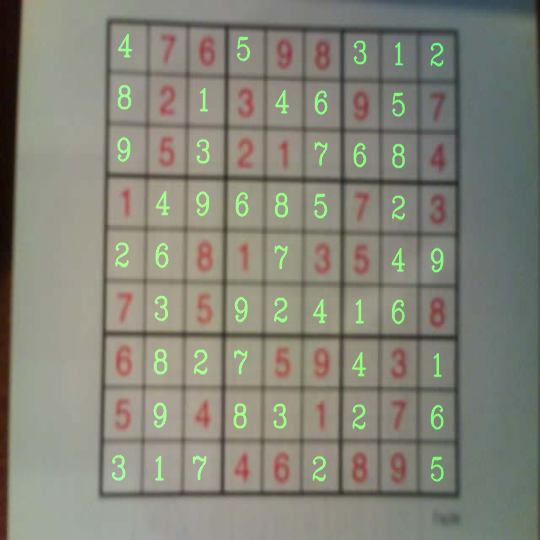

In [16]:
import numpy as np
import cv2
import time

# Import the necessary patch for displaying images in Colab
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

obrazky = test_images
for i in range(0,obrazky.shape[0]):

    priklad = obrazky[i, :, :, :]
    model = load_model('model.keras')
    contour_exist, prep_img, frame, contour, contour_line, thresh = check_contour(priklad)
    corners = get_corners(contour)
    result = perspective_transform(frame, (450, 450), corners)
    # Rename 'time' variable from predict function to avoid overwriting the 'time' module
    img_nums, centered_numbers, predicted_matrix, solved_matrix, solution_time = predict(result, model)

    mask = np.zeros_like(result)
    priklad, img_solved = inv_transformation(mask, priklad, predicted_matrix, solved_matrix, corners)

    cv2.imwrite(f'solved_images/pic{i}.jpeg', priklad)

# Use cv2_imshow instead of cv2.imshow
cv2_imshow(priklad)

if cv2.waitKey(0) & 0xFF == ord('q'):
    cv2.destroyAllWindows()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


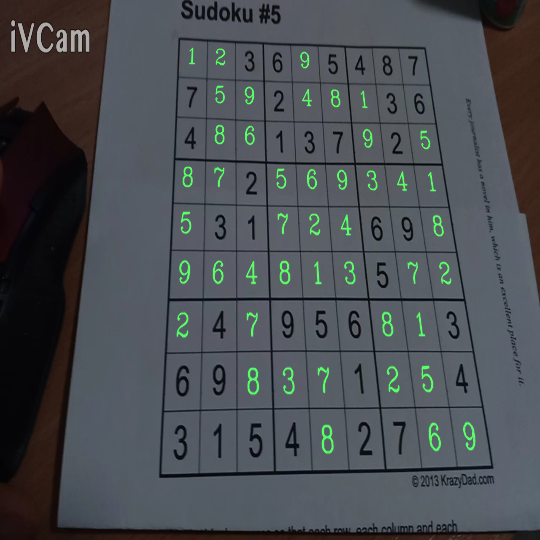

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


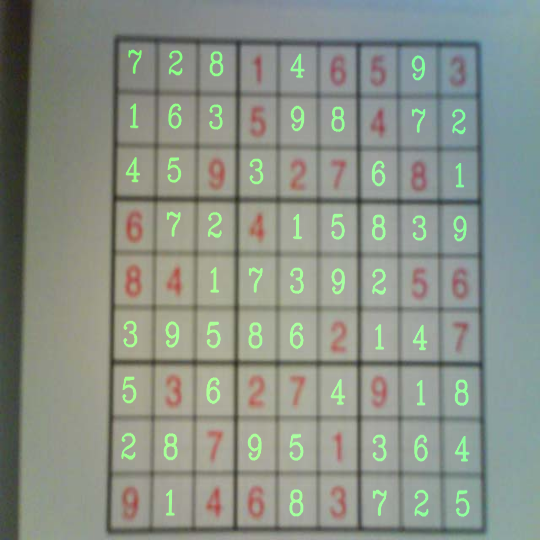

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


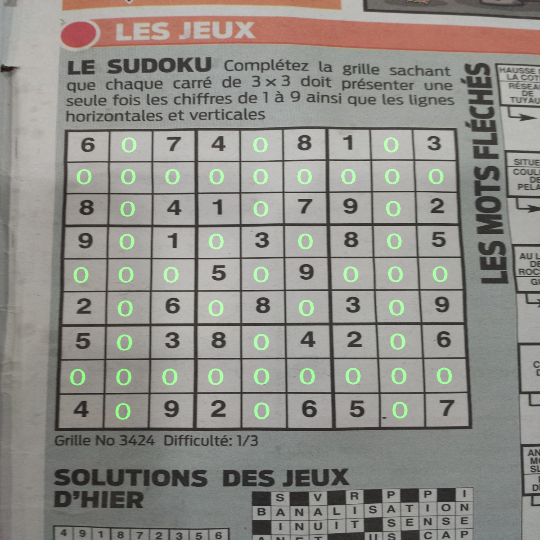

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


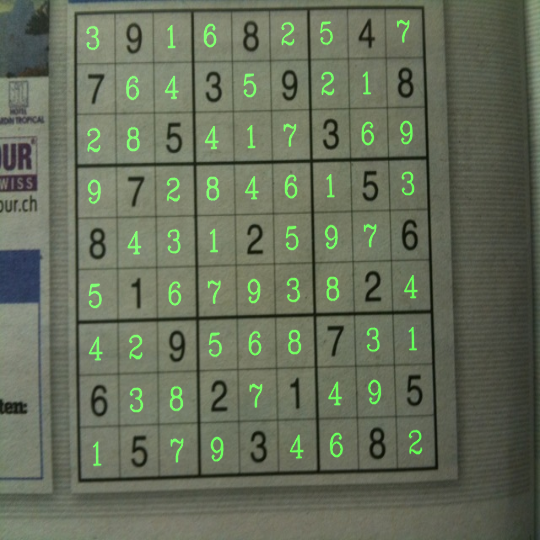

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


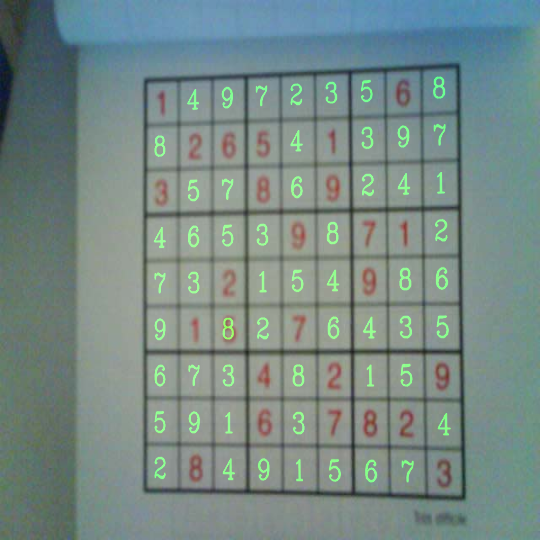

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


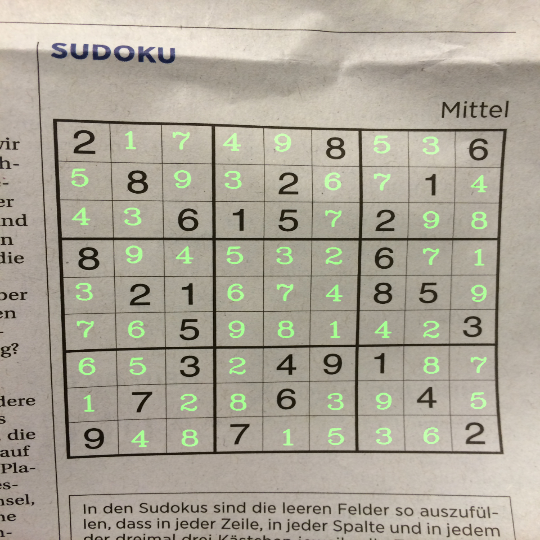

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


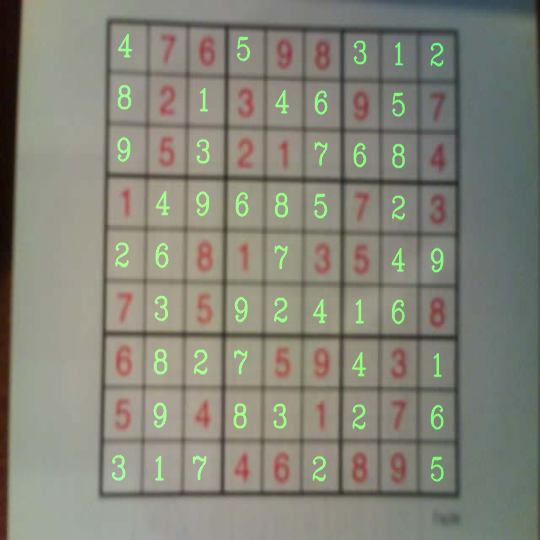

In [17]:

# Import the necessary patch for displaying images in Colab
from google.colab.patches import cv2_imshow

obrazky = test_images
for i in range(0,obrazky.shape[0]):

    priklad = obrazky[i, :, :, :]
    model = load_model('model.keras')
    contour_exist, prep_img, frame, contour, contour_line, thresh = check_contour(priklad)
    if contour_exist:
      corners = get_corners(contour)
      result = perspective_transform(frame, (450, 450), corners)
      img_nums, centered_numbers, predicted_matrix, solved_matrix, solution_time = predict(result, model)

      mask = np.zeros_like(result)
      priklad, img_solved = inv_transformation(mask, priklad, predicted_matrix, solved_matrix, corners)

      cv2.imwrite(f'solved_images/pic{i}.jpeg', priklad)

      cv2_imshow(priklad)

      if cv2.waitKey(0) & 0xFF == ord('q'):
          cv2.destroyAllWindows()
    else:
      print(f"No contour found in image {i}")
